# Calculation of detectable Gamma ray burst (GRB) event rate associated with Binary Neutron Star (BNS) mergers.

Analyst: [Hemanta Ph.](https://hemantaph.notion.site/Hemanta-Ph-b4c52e857d424c0db2a68f4e63d6097f), Anupreeta More, Otto Hannuksela.

Notes:

* This is without considering a particular detectors' sensitivity, but rather a general calculation of the rate of detectable GRBs based of viewing angle and luminosity distance. I have considered the inclination angle gravitational waves same as the viewing angle wrt GRB jet axis.

* It involves constructing Pdet (detection probability) function based off luminosity function.

* For BNS source redshift and mass distribution, refer [here](https://ler.readthedocs.io/en/latest/GW_events.html).

* For lens and image properties, refer [here](https://ler.readthedocs.io/en/latest/Lensed_events.html).

* Both SWIFT and FERMI detectors are considered.

* All analysis will be limited to redshift $z\in [0,5]$.

## Result summary

### Condition 1 (EM->GW)

Steps:
1. Sample GRB detectable events from BNS merger events.
2. Calculate rate
3. Check, out of these GRB detectable events, how many are detectable in GWs.

I will consider sub-threshold events as detectable (snr>6).

<!-- | Event | Unlensed | Lensed | Lensed:Unlensed |
| --- | --- | --- | --- |
| GRB | 11528.48 | 10.49 | 1:1099 |
| GW(snr>8) | 2.16 | 4.41e-3 | 1:489.8 |
| GW(snr>8):GRB | 1:5333.33 | 1:2380.95 | - |
| GW(snr>6) | 4.24 | 9.66e-3 | 1:438.92 |
| GW(snr>6):GRB | 1:2721.09 | 1:1086.96 | - | -->
| Event         | Unlensed  | Lensed    | Lensed:Unlensed |
| ---           | ---       | ---       | ---             |
| GRB           | 11543.22  | 10.60     | 1:1088.98       |
| GW(snr>8)     | 2.39      | 4.35e-3   | 1:549.42        |
| GW(snr>8):GRB | 1:4819.28 | 1:2439.02 | -               |
| GW(snr>6)     | 4.93      | 1.03e-2   | 1:478.64        |
| GW(snr>6):GRB | 1:2339.18 | 1:1030.93 | -               |

### Condition 2 (GW->EM)

Steps:
1. Sample GW detectable events from BNS merger events.
2. Calculate rate
3. Check, out of these GW detectable events, how many are detectable in GRBs.

I will consider super-threshold events only (snr>8).

<!-- | Event | Unlensed | Lensed | ratio[Unlensed/Lensed] |
| --- | --- | --- | --- |
| GW(snr>8) | 20 | 4.86e-2 | 1:411.52 |
| GRB (associated) | 1.82 | 3.93e-3 | 1:463.10 |
| ratio[GRB/GW(snr>8)] | 1:11 | 1:12.36 | - |
| GW(snr>6) | 46.8 | 1.36e-1 | 1:344.12 |
| GRB (associated) | 4.38 | 9.66e-3 | 1:453.42 |
| ratio[GRB/GW(snr>6)] | 1:10.68 | 1:14.11 | - | -->
<!-- | Event | Unlensed | Lensed | ratio[Unlensed/Lensed] |
| --- | --- | --- | --- |
| GW(snr>8) | 20.2 | 5.26e-2 | 1:384 |
| GRB (associated) | 1.81 | 3.63e-3 | 1:498.62 |
| GRB:GW(snr>8) | 1:11.12 | 1:14.48 | - | -->
| Event            | Unlensed | Lensed  | Lensed:Unlensed |
| ---              | ---      | ---     | ---             |
| GW(snr>8)        | 21.07    | 5.26e-2 | 1:400.57        |
| GRB (associated) | 1.91     | 3.91e-3 | 1:488.49        |
| GRB:GW(snr>8)    | 1:11.01  | 1:13.45 | -               |

### Combined plot of viewing angle vs redshift for both conditions (left: Codition1, right: Condition2).

<p align="center">
  <img src="./combined final.png" alt="Your Logo" width="200%" style="margin: 0; padding: 0;">
</p>

## Equations (GRB)

* Ref: [Howell et. al. (2019)](https://arxiv.org/pdf/1811.09168)

* The luminosity function of GRBs is given by:

$$L(\theta_{V})=L_{c}\text{exp}(-\frac{\theta^{2}}{2\theta_{c}^{2}})$$

* Here, $L(\theta_{V})$ is the luminosity at viewing angle $\theta_{V}$, $L_{c}$ is the luminosity at the jet axis, $\theta$ is the viewing angle, and $\theta_{c}$ is the core angle of the jet.

* The paper gives: $\theta_{c} = 5$ degree.

* I will infer the probability of detection from the above equations.

$$P_{det}(\theta,D_L) = \left\{ 
  \begin{array}{ c l }
    1 & \text{if } \theta \le 5 \text{ deg and } D_L \le 46652 \text{ Mpc } (z\sim 5) \\
    1 & \text{if } \frac{\text{a}}{4\pi D_L^2} \text{exp}(-\frac{\theta^{2}}{2\times 21.2^2}) \ge 1 \\
    0 & \text{otherwise}
  \end{array}
\right.$$

* Coefficients a is solved by considering conditions 2 below,
  1. If angle <= 5 deg, distance <= distance_cut, then $P_{det}$ = 1.
  2. pdet=1, If angle=21.2 deg (at distance=40Mpc). This is by considering the GRB from GW170817 would have been difficult to detect if viewing angle>21.2 deg (at distance=40Mpc) or distance>40 Mpc (at angle=21.2 deg).

In [91]:
# calling the necessary libraries
from ler.rates import LeR
import numpy as np
# interpolate
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from ler.utils import get_param_from_json

## Probability of detection of GRBs

### Finding the coefficients

In [92]:
import numpy as np
from scipy.optimize import fsolve

# to find coefficient a
# consider: pdet = 1, If angle = 21.2 deg (at distance=40). 
def equation(a):
    angle = 21.2
    distance = 40
    return a/(4*np.pi*distance**2) * np.exp(-0.5*(angle/5)**2) - 1

a_guess = 10000

# Solve the equation
a_solution = fsolve(equation, a_guess)

print(f"a = {a_solution[0]}")

a = 161107621.34601912


### Function to calculate the probability of detection

In [93]:
# Find distance_cut
# convert redshift to luminoisty distance
import astropy.units as u
from astropy.cosmology import LambdaCDM
cosmo = LambdaCDM(H0=70, Om0=0.3, Ode0=0.7)
# let's assume z = 5 is the distance cut
z = 5
d_L = cosmo.luminosity_distance(z)
print(f"d_L = {d_L}")

d_L = 46652.22297277721 Mpc


In [94]:
class GRB:
    def __init__(self,
    z_min = 0, # minimum redshift
    z_max = 10, # maximum redshift 
    core_angle = 5, # core angle in degrees
    distance_cut = 46652.22297277721, # distance cut in Mpc for z=5
    cosmo = LambdaCDM(H0=70, Om0=0.3, Ode0=0.7), # cosmology
    ):
        self.core_angle = core_angle
        self.distance_cut = distance_cut
        self.cosmo = cosmo
        self.coefficient = self.coefficient_finder()

        # interpolate and find luminosity distance to redshift conversion
        z = np.geomspace(z_min+0.0001, z_max, 10000)
        d_L = cosmo.luminosity_distance(z).value
        self.z_to_dl = interp1d(z, d_L, kind='cubic', fill_value='extrapolate')
        self.dl_to_z = interp1d(d_L, z, kind='cubic', fill_value='extrapolate')

    def coefficient_finder(self, a_guess = 10000):
        """
        Function to find the coefficient 'a' in the GRB pdet model.
        pdet = a/(4*np.pi*distance**2) * np.exp(-0.5*(angle/5)**2){2\times 21.2^2})
        pdet = 1, If angle = 21.2 deg (at distance=40).

        Parameters
        ----------
        a_guess : float
            Initial guess for the coefficient 'a'
            default is 10000

        Returns
        -------
        float
            Coefficient 'a' in the GRB pdet model
        """
        def equation(a):
            # wrt to GW170817
            angle = 21.2
            distance = 40
            return a/(4*np.pi*distance**2) * np.exp(-0.5*(angle/5)**2) - 1

        a_solution = fsolve(equation, a_guess)
        return a_solution[0]
    
    def pdet_grb(self, angle, distance, distance_cut=None, duty_cycle=0.5, mask_duty_cycle=True, bool=True, pdet_cut=1.):
        """
        Function to calculate the probability of detection for a given angle and distance (Mpc) for GRB. 

        Parameters
        ----------
        angle : numpy.ndarray
            Angle between the GRB jet and viewing angle in (rad)
        distance : numpy.ndarray
            Distance between the GRB source and the satellite in (Mpc)
        distance_cut : float
            Core angular size of the GRB jet in (rad)
            default is 25422.742 Mpc
        duty_cycle : float
            Duty cycle of detector(s)
            default is 0.5 (50%: for Fermi-GBM and Swift-BAT combined)
        bool : bool
            if True, return absolute value of pdet
            if False, return the pdet value as boolean (with duty cycle applied)

        Returns
        -------
        numpy.ndarray
            Probability of detection for a given angle and distance
        """

        a = self.coefficient
        jet_angle_cut = self.core_angle
        if distance_cut is None:
            distance_cut = self.distance_cut

        # make sure that the input data is a numpy array
        angle, distance = np.array([angle]).reshape(-1), np.array([distance]).reshape(-1)

        # angle should be less than 90 or equal to 90
        if len(angle[angle > 90]) > 0:
            angle[angle > 90] = angle[angle > 90]%90

        if bool:
            # calculate the probability of detection, absolute value
            pdet = abs(a/(4*np.pi*distance**2) * np.exp(-0.5*(angle/jet_angle_cut)**2))

            # find idx of angle <= jet_angle_cut and distance <= distance_cut
            idx = (angle <= jet_angle_cut) & (distance <= distance_cut)
            # apply the condition, condition 1 from docstring
            pdet[idx] = 1

            # apply the duty cycle
            if mask_duty_cycle:
                # sample random numbers from 0 to 1 and check if it is less than the duty cycle
                num_ = np.random.rand(len(angle))
                mask_duty_cycle = num_ > duty_cycle
                pdet[mask_duty_cycle] = 0

            # return the pdet as boolean
            return (pdet>=pdet_cut).astype(int)
        else:
            # return the probability of detection (absolute value)
            return abs(a/(4*np.pi*distance**2) * np.exp(-0.5*(angle/jet_angle_cut)**2))
    
    def pdet_calculator(self, gw_param_dict, duty_cycle=0.5, mask_duty_cycle=True, bool=True, pdet_cut=1.):
        """
        Pdet calculator for GRB. The  inputs and outputs are are compatible with ler package.

        Parameters
        ----------
        gw_param_dict : dict
            dictionary containing the parameters for the GW event
        duty_cycle : float
            Duty cycle of detector(s)
            default is 0.5 (50%: for Fermi-GBM and Swift-BAT combined)
        mask_duty_cycle : bool
            if True, apply the duty cycle
            default is True
        bool : bool
            if True, return absolute value of pdet
            if False, return the pdet value as boolean (with duty cycle applied)

        Returns
        -------
        dict
            dictionary containing the probability of detection for the given GW event
        """

        # get the angle and distance from the dictionary
        angle = np.degrees(gw_param_dict['theta_jn'])
        if 'luminosity_distance' in gw_param_dict:
            distance = gw_param_dict['luminosity_distance']
        elif 'effective_luminosity_distance' in gw_param_dict:
            distance = gw_param_dict['effective_luminosity_distance']

        # calculate the probability of detection
        pdet = self.pdet_grb(angle, distance, duty_cycle=duty_cycle, mask_duty_cycle=mask_duty_cycle, bool=bool, pdet_cut=pdet_cut)
        pdet_net_dict = dict(pdet_net=pdet)

        # return the pdet
        return pdet_net_dict

In [95]:
# class initialization
grb = GRB()

In [96]:
# test the pdet_grb function
angle = np.array([1, 1, 20, 90])
distance = np.array([46652, 46653, 40, 40])
print(grb.pdet_grb(angle, distance, mask_duty_cycle=False, bool=True))

[1 0 1 0]


In [97]:
# test the pdet_calculator function
gw_param_dict = {'theta_jn': np.radians(np.array([1, 21.2, 90])), 'luminosity_distance': np.array([2500, 40, 40])}
print(grb.pdet_calculator(gw_param_dict, mask_duty_cycle=False, bool=True))

{'pdet_net': array([1, 1, 0])}


### Plot detection and non-detection regions

In [98]:
# generate random data
angle = np.random.uniform(0, 30, 5000)
log10_distance = np.random.uniform(0, 5, 5000)
distance = 10**log10_distance
redshift = grb.dl_to_z(distance)

pdet = grb.pdet_grb(angle, distance, mask_duty_cycle=False, bool=True)

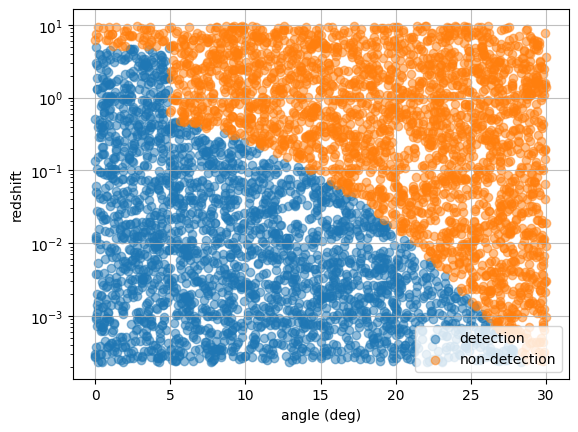

In [99]:
# blue: detection, red: non-detection
plt.scatter(angle[pdet==1], redshift[pdet==1], c='C0', label="detection", alpha=0.5)
plt.scatter(angle[pdet==0], redshift[pdet==0], c='C1', label="non-detection", alpha=0.5)

# draw a horizontal line for GW170817, 40Mpc
# plt.hlines(y=grb.dl_to_z(40), xmin=min(angle)-1, xmax=max(angle)+1, colors='C3', linestyles='solid', label='40Mpc, GW170817')

plt.xlabel("angle (deg)")
plt.ylabel("redshift")
plt.yscale("log")
plt.legend()
plt.grid(alpha=0.8)
plt.show()

## Rate calculation of GRB with LeR

All the necessary functions and parameters are defined below.

**Source related:**
* source frame mass: m1 and m2 sample from [double Gaussian](https://ler.readthedocs.io/en/latest/GW_events.html#BNS-mass-distribution:-Bimodal-Gaussian-Model) model lim[1,2.3]Mo
* Geocent time period: uniform prior, 1 year GPS: {'min_': 1238166018, 'max_': 1269702018}
* Redshift: 0 to 5, uniform, 
  * this follows [merger rate density distribution](https://ler.readthedocs.io/en/latest/GW_events.html#Merger-Rate-Density-Formula)
* ra:  sampler_uniform {'min_': 0.0, 'max_': 6.283185307179586}
* dec:  sampler_cosine [-np.pi/2, np.pi/2]
* phase : sampler_uniform {'min_': 0.0, 'max_': 6.283185307179586}
* psi: sampler_uniform {'min_': 0.0, 'max_': 3.141592653589793}
* theta_jn: sampler_uniform {'min_': 0.0, 'max_': 3.141592653589793}

**Lens related**
* Optical depth: SIE , 
  * so zs for lensed are rejection sampled with optical depth. 
* Lens redshifts: SDSS catalogue (0 to zs), the function of zs Reenske et al. 2021 ( eqnC13). [`ler` function](https://github.com/hemantaph/ler/blob/bce3330638a13ee0883d19633abb17b98791c901/ler/lens_galaxy_population/jit_functions.py#L218)
* Velocity dispersion: gengamma, Haris et al 2018, a=2.32 / 2.67, c=2.67, vd_min=0., vd_max=600.(https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gengamma.html) use in Haris et al upto zs~1.5 (with a=2.32 / 2.67, c=2.67)
* Axis ratio: Raleigh (with Velocity dispersion dependence) {'q_min': 0.2, 'q_max': 1.0}
* axis_rotation_angle : uniform {'phi_min': 0.0, 'phi_max': 6.283185307179586}
* shear: normal {'scale': 0.05}
* mass_density_spectral_index: normal {'mean': 2.0, 'std': 0.2}

**Image related:**
* Strong lensing condition: num_images>=2
* Lens equation solver: EPL+Shear, `lenstronomy`
* Source position: sample within caustic,  Ewoud et. al. 2022

In [100]:
ler = LeR(
    npool=8,
    verbose=False,
    z_max=10,
    pdet_finder=grb.pdet_calculator,
    source_priors={'theta_jn': 'sampler_uniform',},
    source_priors_params={'theta_jn': {'min_': 0, 'max_': np.pi},},
    event_type='BNS',
    mtot_max=51,
    ifos=['L1','H1','V1'],
)

### Unlensed events

In [101]:
unlensed_param_detectable = ler.selecting_n_unlensed_detectable_events(
    size=400000,
    batch_size=200000,
    resume=True,
    trim_to_size=True,
    detectability_condition="pdet",
    output_jsonfile="n_unlensed_params_detectable_grb2.json",
    meta_data_file="meta_unlensed_grb2.json",
)

collected number of detectable events =  400000
storing detectable unlensed params in ./ler_data/n_unlensed_params_detectable_grb2.json
storing meta data in ./ler_data/meta_unlensed_grb2.json

 trmming final result to size=400000
collected number of detectable events =  400000
total number of events =  15831983.0
total unlensed rate (yr^-1): 11545.577217444617


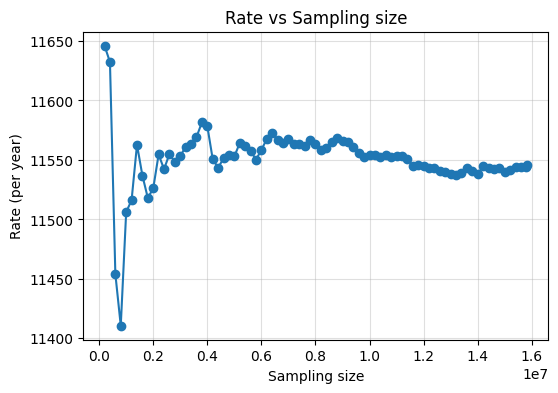

In [102]:
# getting data from json
meta_data= get_param_from_json("ler_data/meta_unlensed_grb2.json")

# plot the rate vs sampling size
plt.figure(figsize=(6,4))
plt.plot(meta_data['events_total'], meta_data['total_rate'], 'o-')
plt.xlabel('Sampling size')
plt.ylabel('Rate (per year)')
plt.title('Rate vs Sampling size')
plt.grid(alpha=0.4)
plt.show()

In [103]:
# select only events after sampling size of 
idx = np.where(meta_data['events_total'] > 1.4e7)[0]
# take average 
grb_rate_unlensed1 = np.mean(meta_data['total_rate'][idx])
print('Unlensed GRB Rate (per year) =', grb_rate_unlensed1)

Unlensed GRB Rate (per year) = 11543.221199013773


### Checking how many of these events are detectable in GWs

In [104]:
# gwsnr will be used to calculate the SNR of the associated GW event
ler = LeR(
    verbose=False,
    z_max=10,
    event_type='BNS',
    source_priors={'theta_jn': 'sampler_uniform',},
    source_priors_params={'theta_jn': {'min_': 0, 'max_': np.pi},},
    mtot_max=51,
    ifos=['L1','H1','V1'],
)

In [105]:
# get the generated unlensed parameters
unlensed_param_detectable = get_param_from_json("ler_data/n_unlensed_params_detectable_grb2.json")
# calculate the SNR of the associated GW event
snr_unlensed = ler.snr(gw_param_dict=unlensed_param_detectable)['optimal_snr_net']

In [106]:
# super-threshold only
# number of detectable events in terms of GW snr out of already detected events in term of GRB pdet
print(f"Number of unlensed detectable events in terms of GW snr is {np.sum(snr_unlensed>8)} \nout of {len(snr_unlensed)} events that are already detected in terms of GRB pdet\n")

print(f"if the rate of detectable unlensed GRBs is {grb_rate_unlensed1}, \nthen the rate of detectable GWs is {grb_rate_unlensed1*np.sum(snr_unlensed>8)/len(snr_unlensed)}\n")

print(f"ratio (unlensed detectable GRBs)/(unlensed detectable GWs) = {len(snr_unlensed)/np.sum(snr_unlensed>8)}")

Number of unlensed detectable events in terms of GW snr is 83 
out of 400000 events that are already detected in terms of GRB pdet

if the rate of detectable unlensed GRBs is 11543.221199013773, 
then the rate of detectable GWs is 2.395218398795358

ratio (unlensed detectable GRBs)/(unlensed detectable GWs) = 4819.277108433735


In [107]:
# sub-threshold considered
# number of detectable events in terms of GW snr out of already detected events in term of GRB pdet
print(f"Number of unlensed detectable events in terms of GW snr is {np.sum(snr_unlensed>6)} \nout of {len(snr_unlensed)} events that are already detected in terms of GRB pdet\n")

print(f"if the rate of detectable unlensed GRBs is {grb_rate_unlensed1}, \nthen the rate of detectable GWs is {grb_rate_unlensed1*np.sum(snr_unlensed>6)/len(snr_unlensed)}\n")

print(f"ratio (unlensed detectable GRBs)/(unlensed detectable GWs) = {len(snr_unlensed)/np.sum(snr_unlensed>6)}")

Number of unlensed detectable events in terms of GW snr is 171 
out of 400000 events that are already detected in terms of GRB pdet

if the rate of detectable unlensed GRBs is 11543.221199013773, 
then the rate of detectable GWs is 4.934727062578388

ratio (unlensed detectable GRBs)/(unlensed detectable GWs) = 2339.1812865497077


### Lensed events

In [108]:
ler = LeR(
    npool=8,
    verbose=False,
    z_max=10,
    pdet_finder=grb.pdet_calculator,
    source_priors={'theta_jn': 'sampler_uniform',},
    source_priors_params={'theta_jn': {'min_': 0, 'max_': np.pi},},
    event_type='BNS',
    mtot_max=51,
    ifos=['L1','H1','V1'],
)

In [109]:
lensed_param_detectable = ler.selecting_n_lensed_detectable_events(
    size=100000,
    batch_size=200000,
    # snr_threshold=[8.0,8.0],
    # num_img=[1,1],
    resume=True,
    trim_to_size=True,
    detectability_condition="pdet",
    output_jsonfile="n_lensed_params_detectable_grb2.json",
    meta_data_file="meta_lensed_grb2.json",
)

collected number of detectable events =  100000
storing detectable lensed params in ./ler_data/n_lensed_params_detectable_grb2.json
storing meta data in ./ler_data/meta_lensed_grb2.json

 trmming final result to size=100000
collected number of detectable events =  100000
total number of events =  9442778.0
total unlensed rate (yr^-1): 10.610282744619575


In [110]:
# lensed_param_detectable = get_param_from_json("ler_data/n_lensed_params_detectable_grb2.json")
# zs = lensed_param_detectable['zs']
# viewing_angle = lensed_param_detectable['theta_jn']
# # radian to degree
# viewing_angle = np.degrees(viewing_angle)
# # if angle > 90, then angle = 180 - angle
# viewing_angle[viewing_angle > 90] = viewing_angle[viewing_angle > 90]-90

# # blue: detection, red: non-detection
# plt.scatter(viewing_angle, zs, c='C0', label="detection", alpha=0.5)

# # draw a horizontal line for GW170817, 40Mpc
# # plt.hlines(y=dl_to_z(40), xmin=min(angle)-1, xmax=max(angle)+1, colors='C3', linestyles='solid', label='40Mpc, GW170817')

# plt.xlabel("viewing angle (deg)")
# plt.ylabel("redshiift")
# plt.yscale("log")
# plt.legend()
# plt.grid(alpha=0.8)
# plt.show()

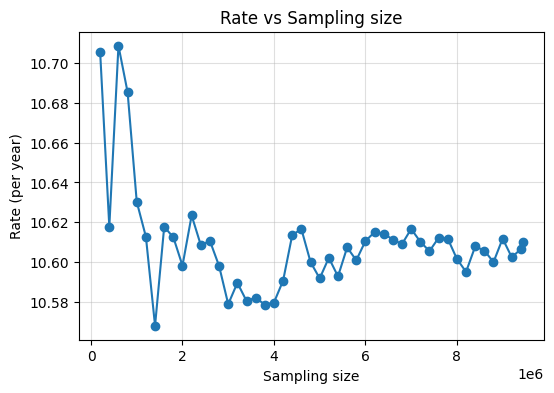

In [111]:
# getting data from json
meta_data= get_param_from_json("ler_data/meta_lensed_grb2.json")

# plot the rate vs sampling size
plt.figure(figsize=(6,4))
plt.plot(meta_data['events_total'], meta_data['total_rate'], 'o-')
plt.xlabel('Sampling size')
plt.ylabel('Rate (per year)')
plt.title('Rate vs Sampling size')
plt.grid(alpha=0.4)
plt.show()

In [112]:
# select only events after sampling size of 
idx = np.where(meta_data['events_total'] > 3e6)[0]
# take average 
grb_rate_lensed1 = np.mean(meta_data['total_rate'][idx])
print('Lensed GRB Rate (per year) =', grb_rate_lensed1)

Lensed GRB Rate (per year) = 10.602504559391095


### Out of the detected GRB events, how many are detectable in GW.

* find out GW detector SNRs of the event which are detectable in GRBs.

* check how many of them cross the SNR threshold

In [113]:
# ler initialization with default snr calculator (gwsnr)
ler = LeR(
    verbose=False,
    z_max=5,
    event_type='BNS',
    source_priors={'theta_jn': 'sampler_uniform',},
    source_priors_params={'theta_jn': {'min_': 0, 'max_': np.pi},},
    mtot_max=51,
    ifos=['L1','H1','V1'],
)

In [114]:
# get snr for the lensed events
lensed_param_detectable = get_param_from_json("ler_data/n_lensed_params_detectable_grb2.json")
snr_lensed, _ = ler.get_lensed_snrs(lensed_param_detectable, list_of_detectors=['L1','H1','V1'], snr_calculator=ler.snr)
snr_lensed = snr_lensed['optimal_snr_net']

In [115]:
# only super-threshold events
num_ =  np.sum(np.sum(snr_lensed>8, axis=1)>=2)
print(f"Number of lensed detectable events in terms of GW snr is {num_} out of {len(snr_lensed)} \nevents that are already detected in terms of GRB pdet\n")

print(f"if the rate of detectable lensed GRBs is {grb_rate_lensed1}, \nthen the rate of detectable GWs is {grb_rate_lensed1*num_/len(snr_lensed)}\n")

print(f"ratio (lensed detectable GRBs)/(lensed detectable GWs) = {len(snr_lensed)/num_}")

Number of lensed detectable events in terms of GW snr is 41 out of 100000 
events that are already detected in terms of GRB pdet

if the rate of detectable lensed GRBs is 10.602504559391095, 
then the rate of detectable GWs is 0.004347026869350349

ratio (lensed detectable GRBs)/(lensed detectable GWs) = 2439.0243902439024


In [116]:
# sub-threshold events considered
num_ =  np.sum(np.sum(snr_lensed>6, axis=1)>=2)
print(f"Number of lensed detectable events in terms of GW snr is {num_} out of {len(snr_lensed)} \nevents that are already detected in terms of GRB pdet\n")

print(f"if the rate of detectable lensed GRBs is {grb_rate_lensed1}, \nthen the rate of detectable GWs is {grb_rate_lensed1*num_/len(snr_lensed)}\n")

print(f"ratio (lensed detectable GRBs)/(lensed detectable GWs) = {len(snr_lensed)/num_}")

Number of lensed detectable events in terms of GW snr is 97 out of 100000 
events that are already detected in terms of GRB pdet

if the rate of detectable lensed GRBs is 10.602504559391095, 
then the rate of detectable GWs is 0.010284429422609362

ratio (lensed detectable GRBs)/(lensed detectable GWs) = 1030.9278350515465


### Detector horizon calculation for BNS

In [117]:
from gwsnr import GWSNR
gwsnr = GWSNR(
    mtot_max=51,
    ifos=['L1','H1','V1'],
    gwsnr_verbose=False,
)

Interpolator will be loaded for L1 detector from ./interpolator_pickle/L1/partialSNR_dict_1.pickle
Interpolator will be loaded for H1 detector from ./interpolator_pickle/H1/partialSNR_dict_1.pickle
Interpolator will be loaded for V1 detector from ./interpolator_pickle/V1/partialSNR_dict_4.pickle


In [118]:
dhor = gwsnr.detector_horizon(mass_1=1.4, mass_2=1.4, snr_th=6, snr_th_net=6)['net'][0]
print(f"Detector Horizon for BNS at SNR=6 is {dhor} Mpc")

100%|█████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.26s/it]

dl_eff 389.5713941459235
optimal_snr_unscaled [32.91841147]
Detector Horizon for BNS at SNR=6 is 2137.345241875989 Mpc


## Plot (GRB with associated GW)

In [119]:
# This will be used to plot the viewing angle vs redshift
unlensed_param_detectable = get_param_from_json("ler_data/n_unlensed_params_detectable_grb2.json")
zs_grb_unlensed = unlensed_param_detectable['zs']
viewing_angle_grb_unlensed = unlensed_param_detectable['theta_jn']
# radian to degree
viewing_angle_grb_unlensed = np.degrees(viewing_angle_grb_unlensed)
# if angle > 90, then angle = 180 - angle
viewing_angle_grb_unlensed[viewing_angle_grb_unlensed > 90] = viewing_angle_grb_unlensed[viewing_angle_grb_unlensed > 90]-90

In [120]:
lensed_param_detectable = get_param_from_json("ler_data/n_lensed_params_detectable_grb2.json")
zs_grb_lensed = lensed_param_detectable['zs']
viewing_angle_grb_lensed = lensed_param_detectable['theta_jn']
# radian to degree
viewing_angle_grb_lensed = np.degrees(viewing_angle_grb_lensed)
# if angle > 90, then angle = 180 - angle
viewing_angle_grb_lensed[viewing_angle_grb_lensed > 90] = viewing_angle_grb_lensed[viewing_angle_grb_lensed > 90]-90

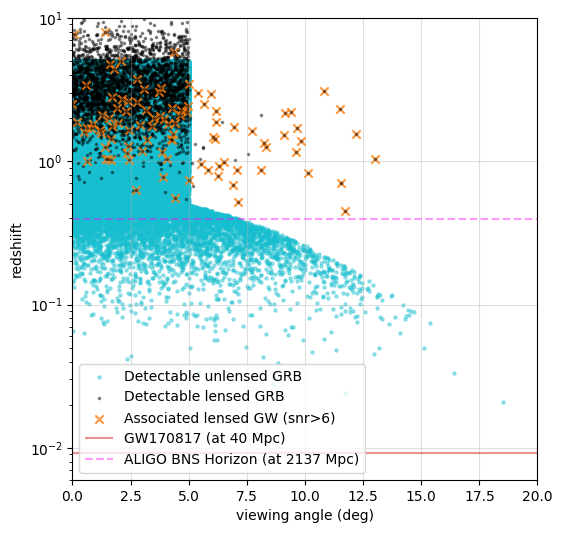

In [121]:
# blue: detection, red: non-detection
num_ = np.round(len(viewing_angle_grb_lensed)/30)
idx_ = np.random.choice(len(viewing_angle_grb_lensed), int(num_), replace=False)

plt.figure(figsize=(6,6))

# unlensed GRB
plt.scatter(viewing_angle_grb_unlensed, zs_grb_unlensed, c='C9', label="Detectable unlensed GRB", alpha=0.4, marker='.', s=20)

# lensed GRB
plt.scatter(viewing_angle_grb_lensed[idx_], zs_grb_lensed[idx_], c='k', label="Detectable lensed GRB", alpha=0.4, marker='.', s=10)

# lensed GW, only snr_lensed>6
idx_ = np.sum(snr_lensed>6, axis=1)>=2
plt.scatter(viewing_angle_grb_lensed[idx_], zs_grb_lensed[idx_], c='C1', label="Associated lensed GW (snr>6)", alpha=0.8, marker='x')
plt.scatter(viewing_angle_grb_lensed[idx_], zs_grb_lensed[idx_], c='k', alpha=0.4, marker='.', s=10)

# unlensed GW, only snr_unlensed>6
# idx_ = snr_unlensed>6
# plt.scatter(viewing_angle_grb_unlensed[idx_], zs_grb_unlensed[idx_], c='r', label="Associated unlensed GW (snr>6)", alpha=0.8, marker='x')
# plt.scatter(viewing_angle_grb_unlensed[idx_], zs_grb_unlensed[idx_], c='C9', alpha=0.9, marker='.', s=10)

# draw a horizontal line for GW170817, 40Mpc
plt.hlines(y=grb.dl_to_z(40), xmin=0, xmax=20, colors='C3', linestyles='solid', label='GW170817 (at 40 Mpc)', alpha=0.5)

# dhor 
plt.hlines(y=grb.dl_to_z(2137), xmin=0, xmax=20, colors='magenta', linestyles='dashed', label="ALIGO BNS Horizon (at 2137 Mpc)", alpha=0.4)

plt.xlabel("viewing angle (deg)")
plt.ylabel("redshiift")
#plt.title("Detectable GRB vs associated detectable GW")
plt.yscale("log")
plt.xlim(0., 20)
plt.ylim(0.006, 10)
plt.legend(loc='lower left')
plt.grid(alpha=0.4)
# save the plot
plt.savefig("grb with associated gw final.png", dpi=400)
plt.show()

### Table for GRB rates and associate GW rates

| Event         | Unlensed  | Lensed    | Lensed:Unlensed |
| ---           | ---       | ---       | ---             |
| GRB           | 11543.22  | 10.60     | 1:1088.98       |
| GW(snr>8)     | 2.39      | 4.35e-3   | 1:549.42        |
| GW(snr>8):GRB | 1:4819.28 | 1:2439.02 | -               |
| GW(snr>6)     | 4.93      | 1.03e-2   | 1:478.64        |
| GW(snr>6):GRB | 1:2339.18 | 1:1030.93 | -               |

Remarks

- GRB rate: 1 lensed GRB out of 1099  GRBs
- GW rate: 1 lensed GW(snr>6) out of 1087 lensed GRBs, i.e. 1 lensed GW out of 1194613 unlensed GRBs
- We might need push the SNR threshold further down to get more lensed GWs.
- But for the unlensed GWs, the rate is 1 GW(snr>6) out of 2721 unlensed GRBs, which is not bad for the current detection capability.

## Case II: GW detection first

# Unlensed events

In [122]:
ler = LeR(
    verbose=False,
    z_max=10,
    event_type='BNS',
    source_priors={'theta_jn': 'sampler_uniform',},
    source_priors_params={'theta_jn': {'min_': 0, 'max_': np.pi},},
    mtot_max=51,
    ifos=['L1','H1','V1'],
)

In [123]:
unlensed_param_detectable = ler.selecting_n_unlensed_detectable_events(
    size=5000,
    batch_size=200000,
    snr_threshold=8.0,
    resume=True,
    trim_to_size=True,
    output_jsonfile="n_unlensed_params_detectable_gw_super2.json",
    meta_data_file="meta_unlensed_gw_super2.json",
)

collected number of detectable events =  5000
storing detectable unlensed params in ./ler_data/n_unlensed_params_detectable_gw_super2.json
storing meta data in ./ler_data/meta_unlensed_gw_super2.json

 trmming final result to size=5000
collected number of detectable events =  5000
total number of events =  108647893.0
total unlensed rate (yr^-1): 21.030019219030148


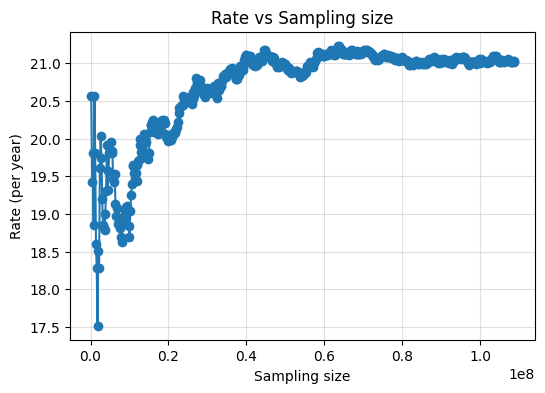

In [124]:
# getting data from json
meta_data= get_param_from_json("ler_data/meta_unlensed_gw_super2.json")

# plot the rate vs sampling size
plt.figure(figsize=(6,4))
plt.plot(meta_data['events_total'], meta_data['total_rate'], 'o-')
plt.xlabel('Sampling size')
plt.ylabel('Rate (per year)')
plt.title('Rate vs Sampling size')
plt.grid(alpha=0.4)
plt.show()

In [125]:
# select only events after sampling size of
idx = np.where(meta_data['events_total'] > 0.6e8)[0]
# take average
gw_rate_unlensed = np.mean(meta_data['total_rate'][idx])
print('Unlensed GW Rate (per year) =', gw_rate_unlensed)

Unlensed GW Rate (per year) = 21.066301441939544


### How many detectable events are there in terms of GRB pdet out of already detected events in terms of GW snr?

In [126]:
unlensed_param_detectable = get_param_from_json('./ler_data/n_unlensed_params_detectable_gw_super2.json')
unlensed_grb_pdet = grb.pdet_calculator(unlensed_param_detectable)

In [127]:
# number of detectable events in terms of GRB pdet out of already detected events in term of GW snr
print(f"Number of unlensed detectable events in terms of GRB pdet is {np.sum(unlensed_grb_pdet['pdet_net']==1)} \nout of {len(unlensed_grb_pdet['pdet_net'])} events that are already detected in terms of GW snr\n")

print(f"if the rate of detectable unlensed GWs is {gw_rate_unlensed}, \nthen the rate of detectable GRBs is {gw_rate_unlensed*np.sum(unlensed_grb_pdet['pdet_net']==1)/len(unlensed_grb_pdet['pdet_net'])}\n")

print(f"ratio (unlensed detectable GWs)/(unlensed detectable GRBs) = {len(unlensed_grb_pdet['pdet_net'])/np.sum(unlensed_grb_pdet['pdet_net']==1)}")

Number of unlensed detectable events in terms of GRB pdet is 463 
out of 5000 events that are already detected in terms of GW snr

if the rate of detectable unlensed GWs is 21.066301441939544, 
then the rate of detectable GRBs is 1.9507395135236016

ratio (unlensed detectable GWs)/(unlensed detectable GRBs) = 10.799136069114471


### Lensed events

In [128]:
ler = LeR(
    npool=8,
    verbose=False,
    z_max=10,
    event_type='BNS',
    source_priors={'theta_jn': 'sampler_uniform',},
    source_priors_params={'theta_jn': {'min_': 0, 'max_': np.pi},},
    mtot_max=51,
    ifos=['L1','H1','V1'],
)

In [138]:
# super-threshold events considered
lensed_param_detectable = ler.selecting_n_lensed_detectable_events(
    size=3378,
    batch_size=200000,
    snr_threshold=[8.0,8.0],
    num_img=[1,1],
    resume=True,
    output_jsonfile="n_lensed_params_detectable_gw_super2.json",
    meta_data_file="meta_lensed_gw_super2.json",
)

collected number of detectable events =  3378.0
storing detectable lensed params in ./ler_data/n_lensed_params_detectable_gw_super2.json
storing meta data in ./ler_data/meta_lensed_gw_super2.json

 trmming final result to size=3378
collected number of detectable events =  3378
total number of events =  64200000.0
total unlensed rate (yr^-1): 0.05271708087779541


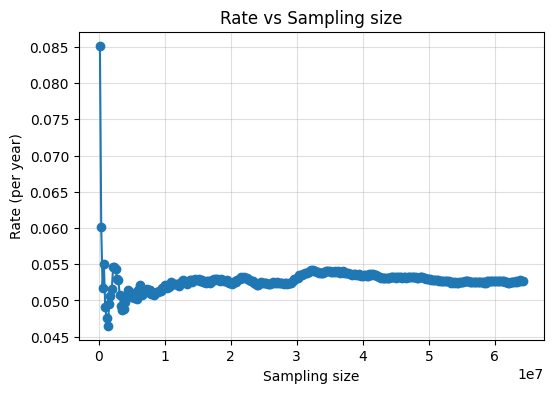

In [139]:
# rate 
meta_data= get_param_from_json("ler_data/meta_lensed_gw_super2.json")

# plot the rate vs sampling size
plt.figure(figsize=(6,4))
plt.plot(meta_data['events_total'], meta_data['total_rate'], 'o-')
plt.xlabel('Sampling size')
plt.ylabel('Rate (per year)')
plt.title('Rate vs Sampling size')
plt.grid(alpha=0.4)
plt.show()

In [144]:
lensed_param_detectable = get_param_from_json("ler_data/n_lensed_params_detectable_gw_super2.json")
# select only events after sampling size of
idx = np.where(meta_data['events_total'] > 5e7)[0]
# take average
gw_rate_lensed = np.mean(meta_data['total_rate'][idx])
print('Lensed GW Rate (per year, sub-threshold considered) =', gw_rate_lensed)

Lensed GW Rate (per year, sub-threshold considered) = 0.0526287620536816


### How many detectable events are there in terms of GRB pdet out of already detected events in terms of GW snr?

In [145]:
lensed_param_detectable = get_param_from_json("ler_data/n_lensed_params_detectable_gw_super2.json")
# get pdet for the lensed events
pdet_lensed,_ = ler.get_lensed_snrs(
    lensed_param=lensed_param_detectable,
    list_of_detectors=['L1','H1','V1'],
    pdet_calculator=grb.pdet_calculator,
)

# only detectable GRBs
num_ =  np.sum(np.sum(pdet_lensed['pdet_net']==1, axis=1)>=2)

In [146]:
# number of detectable events in terms of GRB pdet out of already detected events in term of GW snr
print(f"Number of lensed detectable events in terms of GRB pdet is {num_} \nout of {len(pdet_lensed['pdet_net'])} events that are already detected in terms of GW snr\n")

print(f"if the rate of detectable lensed GWs is {gw_rate_lensed}, \nthen the rate of detectable GRBs is {gw_rate_lensed*num_/len(pdet_lensed['pdet_net'])}\n")

print(f"ratio (lensed detectable GWs)/(lensed detectable GRBs) = {len(pdet_lensed['pdet_net'])/num_}")

Number of lensed detectable events in terms of GRB pdet is 251 
out of 3378 events that are already detected in terms of GW snr

if the rate of detectable lensed GWs is 0.0526287620536816, 
then the rate of detectable GRBs is 0.003910544486522819

ratio (lensed detectable GWs)/(lensed detectable GRBs) = 13.458167330677291


### Detector horizon calculation for BNS

In [147]:
from gwsnr import GWSNR
gwsnr = GWSNR(
    mtot_max=51,
    ifos=['L1','H1','V1'],
    gwsnr_verbose=False,
)

Interpolator will be loaded for L1 detector from ./interpolator_pickle/L1/partialSNR_dict_1.pickle
Interpolator will be loaded for H1 detector from ./interpolator_pickle/H1/partialSNR_dict_1.pickle
Interpolator will be loaded for V1 detector from ./interpolator_pickle/V1/partialSNR_dict_4.pickle


In [148]:
dhor = gwsnr.detector_horizon(mass_1=1.4, mass_2=1.4, snr_th_net=8)['net'][0]
print(f"Detector Horizon for BNS at SNR=6 is {dhor} Mpc")

100%|█████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.39s/it]

dl_eff 389.5713941459235
optimal_snr_unscaled [32.91841147]
Detector Horizon for BNS at SNR=6 is 1603.0089314069917 Mpc


## Plot (GW with associated GRB)

In [149]:
# This will be used to plot the viewing angle vs redshift
unlensed_param_detectable = get_param_from_json("ler_data/n_unlensed_params_detectable_gw_super2.json")
zs_gw_unlensed = unlensed_param_detectable['zs']
viewing_angle_grb_unlensed = unlensed_param_detectable['theta_jn']
# radian to degree
viewing_angle_grb_unlensed = np.degrees(viewing_angle_grb_unlensed)
# if angle > 90, then angle = 180 - angle
viewing_angle_grb_unlensed[viewing_angle_grb_unlensed > 90] = viewing_angle_grb_unlensed[viewing_angle_grb_unlensed > 90]-90

In [150]:
lensed_param_detectable = get_param_from_json("ler_data/n_lensed_params_detectable_gw_super2.json")
zs_gw_lensed = lensed_param_detectable['zs']
viewing_angle_grb_lensed = lensed_param_detectable['theta_jn']
# radian to degree
viewing_angle_grb_lensed = np.degrees(viewing_angle_grb_lensed)
# if angle > 90, then angle = 180 - angle
viewing_angle_grb_lensed[viewing_angle_grb_lensed > 90] = viewing_angle_grb_lensed[viewing_angle_grb_lensed > 90]-90

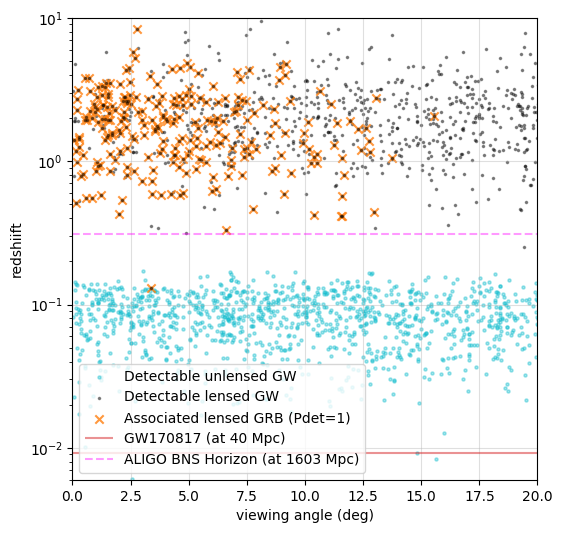

In [151]:
# blue: detection, red: non-detection
# num_ = np.round(len(viewing_angle_grb_lensed)/30)
# idx_ = np.random.choice(len(viewing_angle_grb_lensed), int(num_), replace=False)

plt.figure(figsize=(6,6))

# unlensed GW
plt.scatter(viewing_angle_grb_unlensed, zs_gw_unlensed, c='C9', label="Detectable unlensed GW", alpha=0.4, marker='.', s=20)

# lensed GW
plt.scatter(viewing_angle_grb_lensed, zs_gw_lensed, c='k', label="Detectable lensed GW", alpha=0.4, marker='.', s=10)

# lensed GRB, two or more images pdet=1
idx_ = np.sum(pdet_lensed['pdet_net']==1, axis=1)>=2
plt.scatter(viewing_angle_grb_lensed[idx_], zs_gw_lensed[idx_], c='C1', label="Associated lensed GRB (Pdet=1)", alpha=0.8, marker='x')
plt.scatter(viewing_angle_grb_lensed[idx_], zs_gw_lensed[idx_], c='k', alpha=0.4, marker='.', s=10)

# unlensed GRB, pdet=1
# idx_ = unlensed_grb_pdet['pdet_net']==1
# plt.scatter(viewing_angle_grb_unlensed[idx_], zs_gw_unlensed[idx_], c='r', label="Associated unlensed GW (snr>6)", alpha=0.8, marker='x')
# plt.scatter(viewing_angle_grb_unlensed[idx_], zs_gw_unlensed[idx_], c='C9', alpha=0.9, marker='.', s=10)

# draw a horizontal line for GW170817, 40Mpc
plt.hlines(y=grb.dl_to_z(40), xmin=0, xmax=20, colors='C3', linestyles='solid', label='GW170817 (at 40 Mpc)', alpha=0.5)

# dhor 
plt.hlines(y=grb.dl_to_z(1603), xmin=0, xmax=20, colors='magenta', linestyles='dashed', label="ALIGO BNS Horizon (at 1603 Mpc)", alpha=0.4)

plt.xlabel("viewing angle (deg)")
plt.ylabel("redshiift")
#plt.title("Detectable GRB vs associated detectable GW")
plt.yscale("log")
plt.xlim(0., 20)
plt.ylim(0.006, 10)
plt.legend(loc='lower left')
plt.grid(alpha=0.4)
# save the plot
plt.savefig("gw with associated grb final.png", dpi=400)
plt.show()

### Table for GW rates and associate GRB rates

| Event            | Unlensed | Lensed  | Lensed:Unlensed |
| ---              | ---      | ---     | ---             |
| GW(snr>8)        | 21.07    | 5.26e-2 | 1:400.57        |
| GRB (associated) | 1.91     | 3.91e-3 | 1:488.49        |
| GRB:GW(snr>8)    | 1:11.01  | 1:13.45 | -               |

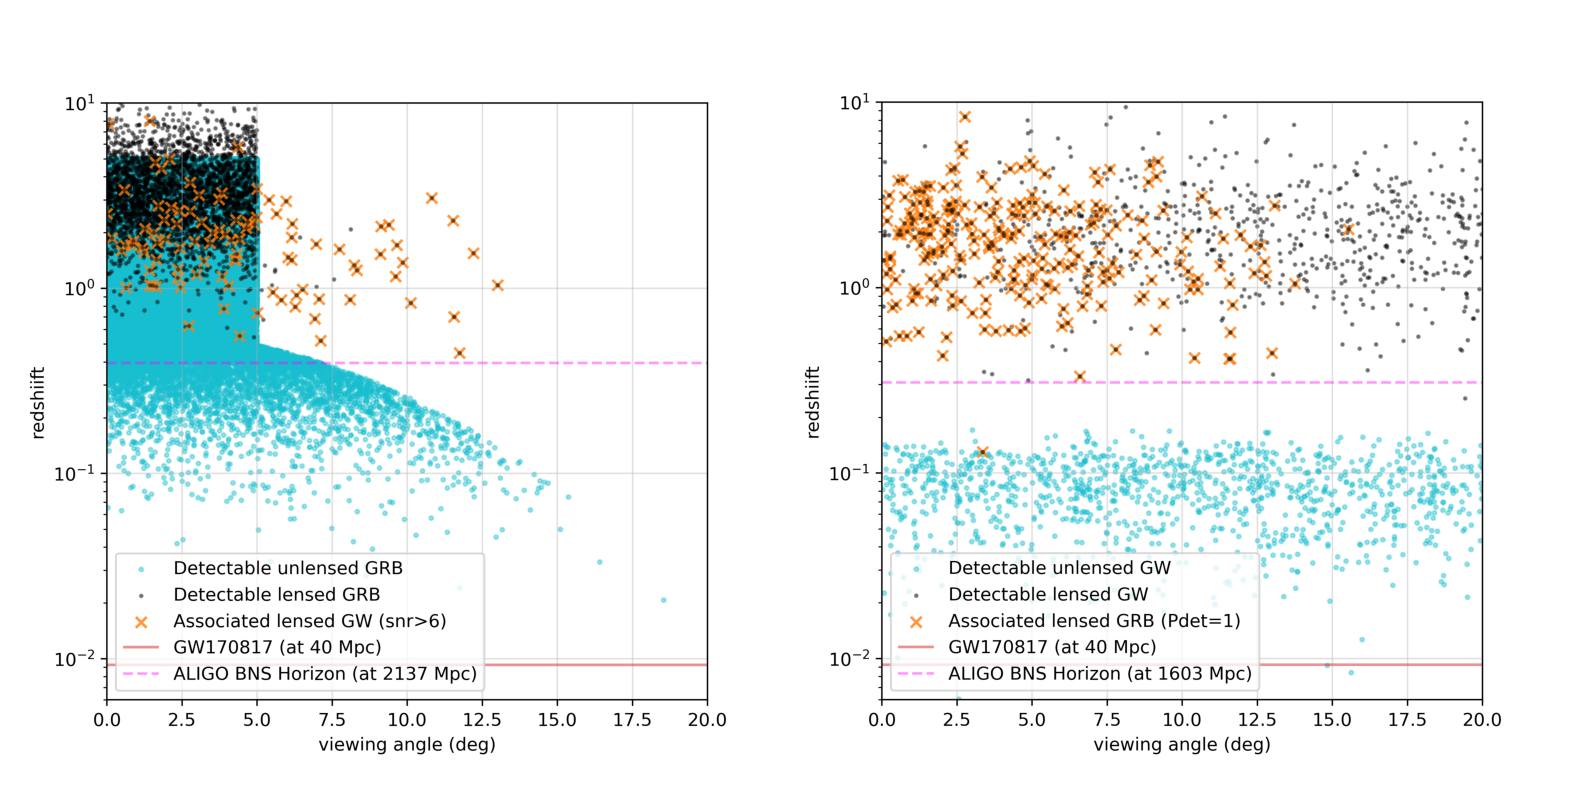

In [152]:
# two plots side by side
fig, axs = plt.subplots(1, 2, figsize=(20,12))
# call png files
img1 = plt.imread("grb with associated gw final.png")
img2 = plt.imread("gw with associated grb final.png")


# plot the images
axs[0].imshow(img1)
axs[0].axis('off')
axs[1].imshow(img2)
axs[1].axis('off')
# increase size of the images
plt.subplots_adjust(wspace=0.0)
# save the plot
plt.savefig("combined final.png", dpi=100)
plt.show()